### Exploratory Data Analysis

In [166]:
!pip install fuzzywuzzy

In [167]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from fuzzywuzzy import process
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from community import community_louvain  # Louvain clustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

### Loading the data

In [168]:
df = pd.read_csv('netflix_titles.csv')

In [169]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### Check for missing values

In [170]:
missing_values = df.isnull().sum()
print(missing_values)

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [171]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

In [172]:
df['listed_in']

,listed_in
0,Documentaries
1,"International TV Shows, TV Dramas, TV Mysteries"
2,"Crime TV Shows, International TV Shows, TV Act..."
3,"Docuseries, Reality TV"
4,"International TV Shows, Romantic TV Shows, TV ..."
...,...
8802,"Cult Movies, Dramas, Thrillers"
8803,"Kids' TV, Korean TV Shows, TV Comedies"
8804,"Comedies, Horror Movies"
8805,"Children & Family Movies, Comedies"


### Splitting the genres

In [173]:
df['genres'] = df['listed_in'].str.split(', ')

In [174]:
df['genres']

,genres
0,[Documentaries]
1,"[International TV Shows, TV Dramas, TV Mysteries]"
2,"[Crime TV Shows, International TV Shows, TV Ac..."
3,"[Docuseries, Reality TV]"
4,"[International TV Shows, Romantic TV Shows, TV..."
...,...
8802,"[Cult Movies, Dramas, Thrillers]"
8803,"[Kids' TV, Korean TV Shows, TV Comedies]"
8804,"[Comedies, Horror Movies]"
8805,"[Children & Family Movies, Comedies]"


In [175]:
df_exploded = df.explode('genres')

In [176]:
df_exploded

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",Documentaries
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",International TV Shows
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",TV Dramas
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",TV Mysteries
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Crime TV Shows
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",Children & Family Movies
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",Comedies
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,Dramas
8806,s8807,Movie,Zubaan,Mozez Singh,"Vicky Kaushal, Sarah-Jane Dias, Raaghav Chanan...",India,"March 2, 2019",2015,TV-14,111 min,"Dramas, International Movies, Music & Musicals",A scrappy but poor boy worms his way into a ty...,International Movies


### Country wise mode

In [177]:
genre_country_mode = df_exploded.groupby('genres')['country'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
)

In [178]:
genre_country_mode

,country
genres,
Action & Adventure,United States
Anime Features,Japan
Anime Series,Japan
British TV Shows,United Kingdom
Children & Family Movies,United States
Classic & Cult TV,United States
Classic Movies,United States
Comedies,United States
Crime TV Shows,United States


### Filling in the missing values for country column

In [179]:
# Map the mode back to the original DataFrame for missing 'country' values
df['country'] = df.apply(
    lambda row: genre_country_mode[row['genres'][0]] if pd.isnull(row['country']) and row['genres'] else row['country'],
    axis=1
)

In [180]:
missing_values = df.isnull().sum()
print(missing_values)


show_id            0
type               0
title              0
director        2634
cast             825
country            0
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
genres             0
dtype: int64


### Exploring the rating column

In [181]:
df.rating.value_counts()
df.rating.replace(['74 min', '84 min', '66 min'], 'TV-MA',inplace=True)

<ipython-input-181-5e3b01016043>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.rating.replace(['74 min', '84 min', '66 min'], 'TV-MA',inplace=True)


In [182]:
df['rating'].unique()

array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', 'NR', nan, 'TV-Y7-FV', 'UR'], dtype=object)

In [183]:
# Get the row with index label '3'
specific_row = df.loc[211]
print(specific_row)


show_id                                                      s212
type                                                        Movie
title                                                Ragini MMS 2
director                                            Bhushan Patel
cast            Sunny Leone, Saahil Prem, Parvin Dabas, Sandhy...
country                                                     India
date_added                                        August 27, 2021
release_year                                                 2014
rating                                                      TV-MA
duration                                                  113 min
listed_in                     Horror Movies, International Movies
description     The horror continues when Ragini's video goes ...
genres                      [Horror Movies, International Movies]
Name: 211, dtype: object


In [184]:
df['genres']

,genres
0,[Documentaries]
1,"[International TV Shows, TV Dramas, TV Mysteries]"
2,"[Crime TV Shows, International TV Shows, TV Ac..."
3,"[Docuseries, Reality TV]"
4,"[International TV Shows, Romantic TV Shows, TV..."
...,...
8802,"[Cult Movies, Dramas, Thrillers]"
8803,"[Kids' TV, Korean TV Shows, TV Comedies]"
8804,"[Comedies, Horror Movies]"
8805,"[Children & Family Movies, Comedies]"


In [185]:
rating_replacements = {
    211: 'TV-14',
    2411: 'TV-14',
    3288: 'PG-13',
    4056: 'TV-G',
    4402: 'TV-G',
    4403: 'TV-G',
    4706: 'TV-14',
    5015: 'TV-14',
    5234: 'TV-14',
    6231: 'TV-Y'
}

for id, rate in rating_replacements.items():
    df.iloc[id, 8] = rate

df['rating'].isna().sum()

4

In [186]:
df.loc[[5989], ['rating']] = 'TV-PG'
df.loc[[6827], ['rating']] = 'TV-14'
df.loc[[7312], ['rating']] = 'TV-PG'
df.loc[[7537], ['rating']] = 'PG-13'

In [187]:
df['rating'].isna().sum()

0

In [188]:
df.loc[df.rating.isin(['TV-Y7-FV']), ['rating']] = 'TV-Y7'
df.loc[df.rating.isin(['TV-G']), ['rating']] = 'G'
df.loc[df.rating.isin(['TV-PG']), ['rating']] = 'PG'
df.loc[df.rating.isin(['TV-MA']), ['rating']] = 'R'
df.loc[df.rating.isin(['NR', 'UR']), ['rating']] = 'nrur'

In [189]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries]
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,R,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]"
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,"September 24, 2021",2021,R,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Crime TV Shows, International TV Shows, TV Ac..."
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,United States,"September 24, 2021",2021,R,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","[Docuseries, Reality TV]"
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,R,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,"[International TV Shows, Romantic TV Shows, TV..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...","[Cult Movies, Dramas, Thrillers]"
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,United States,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...","[Kids' TV, Korean TV Shows, TV Comedies]"
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,"[Comedies, Horror Movies]"
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...","[Children & Family Movies, Comedies]"


### Number of ratings per rating category

<ipython-input-190-9e05b2ef0b1d>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=df.rating,order = df.rating.value_counts().index,palette='rocket')


Text(0.5, 1.0, 'Number of ratings')

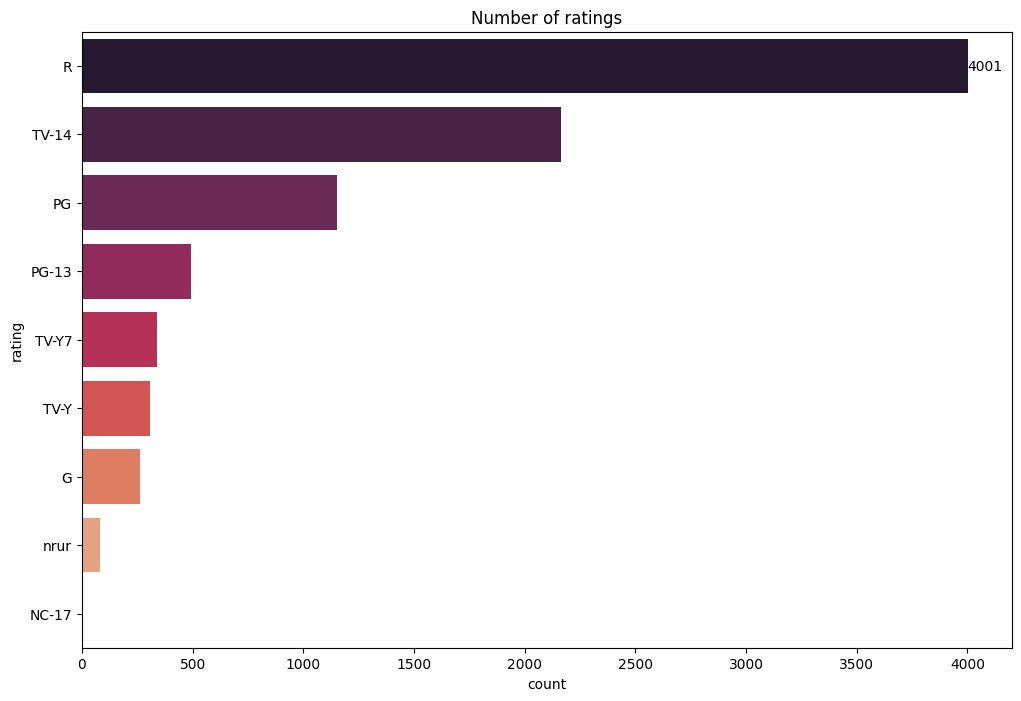

In [190]:
fig, ax = plt.subplots(figsize =(12,8))
ax = sns.countplot(y=df.rating,order = df.rating.value_counts().index,palette='rocket')
ax.bar_label(ax.containers[0])
ax.set_title('Number of ratings')

### Amount of Content per Country

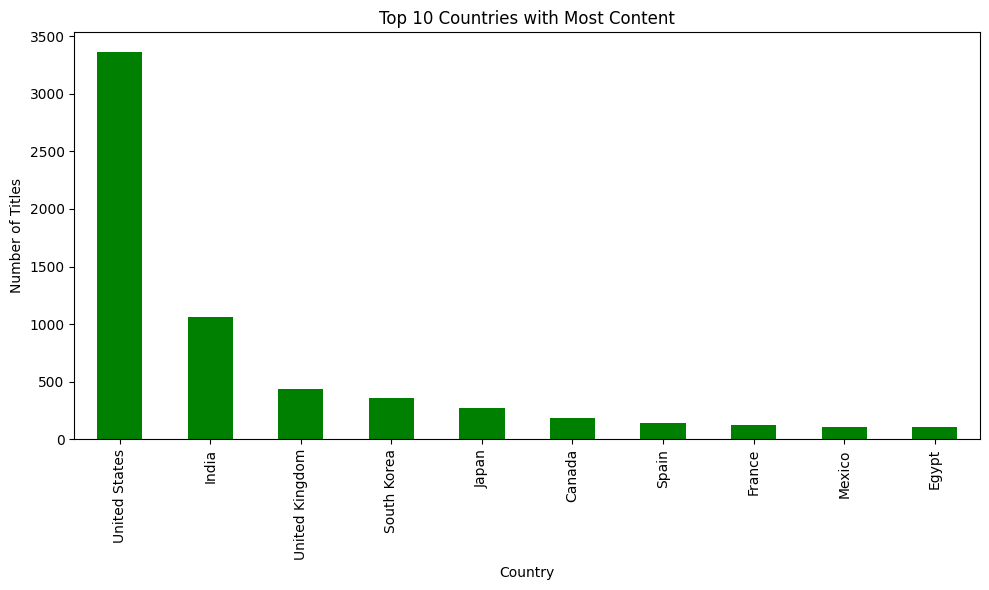

In [191]:
country_counts = df['country'].value_counts()[:10]
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar', color='green')
plt.title('Top 10 Countries with Most Content')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.tight_layout()
plt.show()


### Date time column

In [192]:
# Data Cleaning
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')  # Convert to datetime
df['year_added'] = df['date_added'].dt.year  # Extract year
df['month_added'] = df['date_added'].dt.month  # Extract month
# df['duration'] = df['duration'].fillna('Unknown')  # Handle missing durations

In [193]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],2021.0,9.0
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,R,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",2021.0,9.0
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,R,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Crime TV Shows, International TV Shows, TV Ac...",2021.0,9.0
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,United States,2021-09-24,2021,R,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","[Docuseries, Reality TV]",2021.0,9.0
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,R,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,"[International TV Shows, Romantic TV Shows, TV...",2021.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...","[Cult Movies, Dramas, Thrillers]",2019.0,11.0
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,United States,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...","[Kids' TV, Korean TV Shows, TV Comedies]",2019.0,7.0
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,"[Comedies, Horror Movies]",2019.0,11.0
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...","[Children & Family Movies, Comedies]",2020.0,1.0


In [194]:
df.isnull().sum()

,0
show_id,0
type,0
title,0
director,2634
cast,825
country,0
date_added,98
release_year,0
rating,0
duration,3


In [195]:
# Convert 'year_added' to integers, handling missing values
df['year_added'] = df['year_added'].fillna(0).astype(int)
df['month_added'] = df['month_added'].fillna(0).astype(int)

# Replace 0 with NaN for clarity (optional)
df['year_added'] = df['year_added'].replace(0, pd.NA)
df['month_added'] = df['month_added'].replace(0, pd.NA)


In [196]:
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,genres,year_added,month_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",[Documentaries],2021,9
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,R,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...","[International TV Shows, TV Dramas, TV Mysteries]",2021,9
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,R,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,"[Crime TV Shows, International TV Shows, TV Ac...",2021,9
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,United States,2021-09-24,2021,R,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","[Docuseries, Reality TV]",2021,9
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,R,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,"[International TV Shows, Romantic TV Shows, TV...",2021,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...","[Cult Movies, Dramas, Thrillers]",2019,11
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,United States,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...","[Kids' TV, Korean TV Shows, TV Comedies]",2019,7
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,"[Comedies, Horror Movies]",2019,11
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...","[Children & Family Movies, Comedies]",2020,1


In [197]:
df['duration'].isna().sum()

3

### Number of Movies and TV Shows on Netflix

<ipython-input-198-256a6f6c3f5a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='type', palette='pastel')


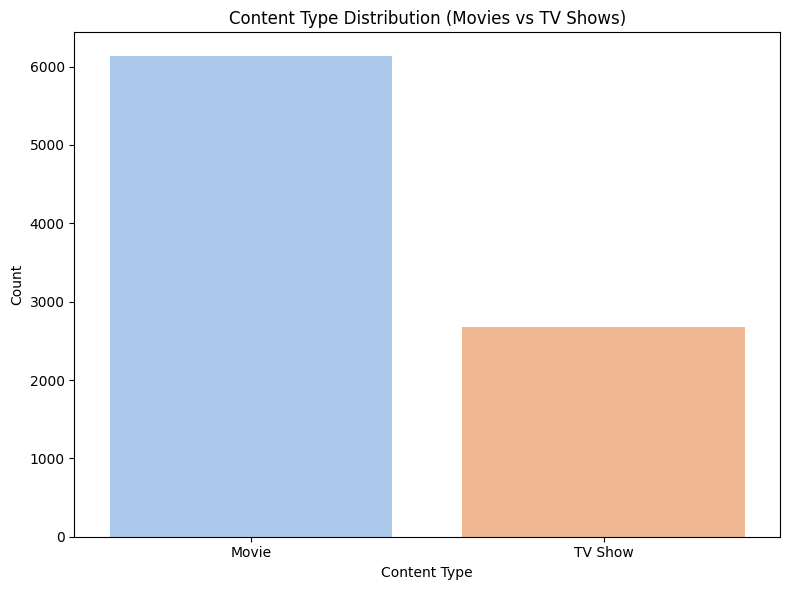

In [198]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type', palette='pastel')
plt.title('Content Type Distribution (Movies vs TV Shows)')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [199]:
df['genres']

,genres
0,[Documentaries]
1,"[International TV Shows, TV Dramas, TV Mysteries]"
2,"[Crime TV Shows, International TV Shows, TV Ac..."
3,"[Docuseries, Reality TV]"
4,"[International TV Shows, Romantic TV Shows, TV..."
...,...
8802,"[Cult Movies, Dramas, Thrillers]"
8803,"[Kids' TV, Korean TV Shows, TV Comedies]"
8804,"[Comedies, Horror Movies]"
8805,"[Children & Family Movies, Comedies]"


### Plot 1: Popular Genres by Region

<Figure size 1600x800 with 0 Axes>

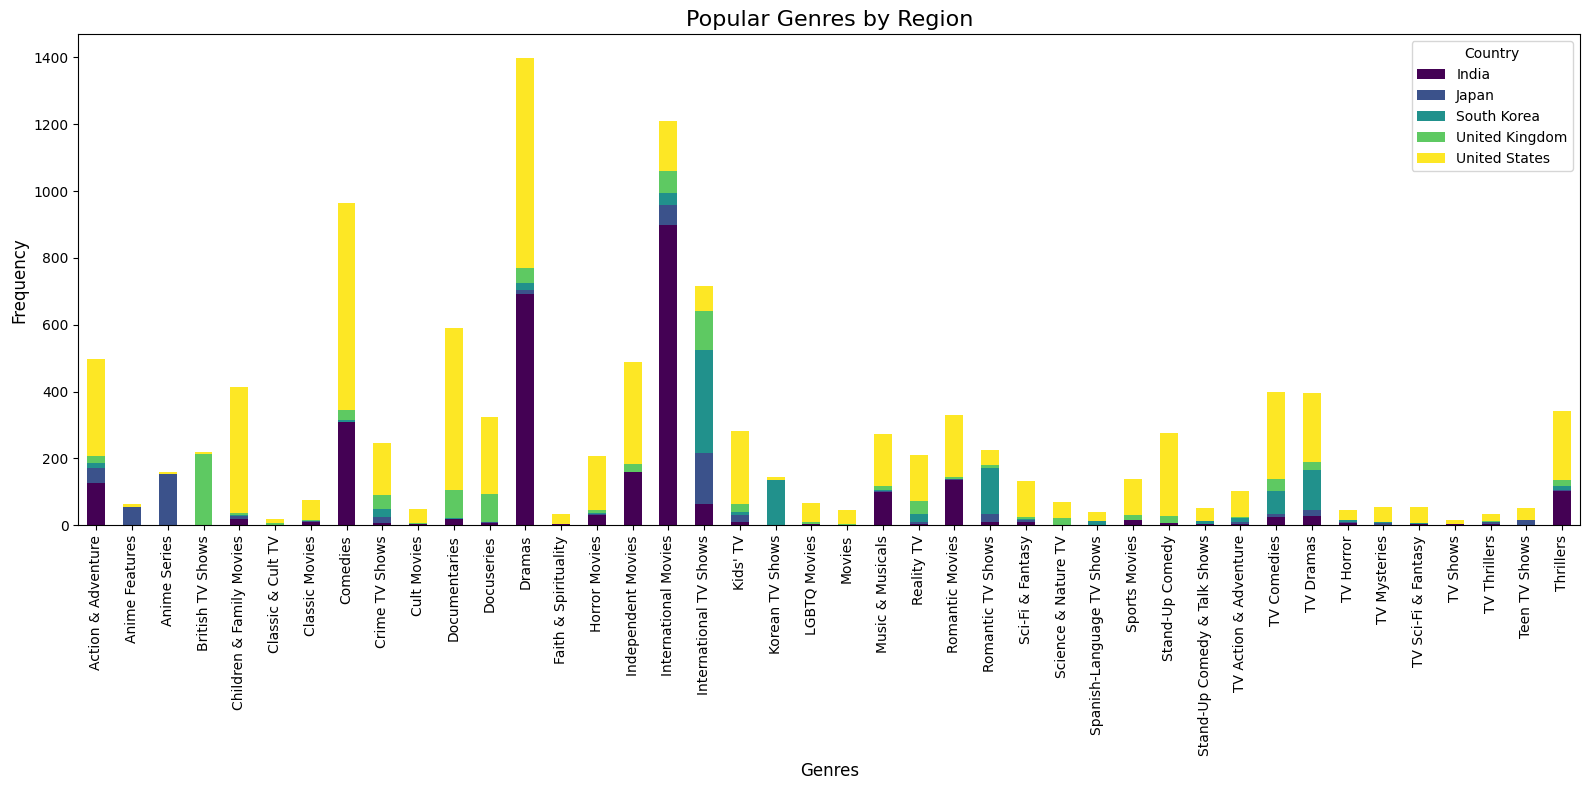

In [200]:
df_exploded = df.explode('genres')

# Filter countries for visualization
top_countries = ['United States', 'India', 'United Kingdom', 'Japan', 'South Korea']
df_filtered = df_exploded[df_exploded['country'].isin(top_countries)]

# Count genres by country
genre_country_counts = df_filtered.groupby(['genres', 'country']).size().unstack().fillna(0)

# Plot
plt.figure(figsize=(16, 8))
genre_country_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(16, 8))
plt.title('Popular Genres by Region', fontsize=16)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Country', fontsize=10)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### # Plot 2: Temporal Trends in Content Production


<Figure size 1200x600 with 0 Axes>

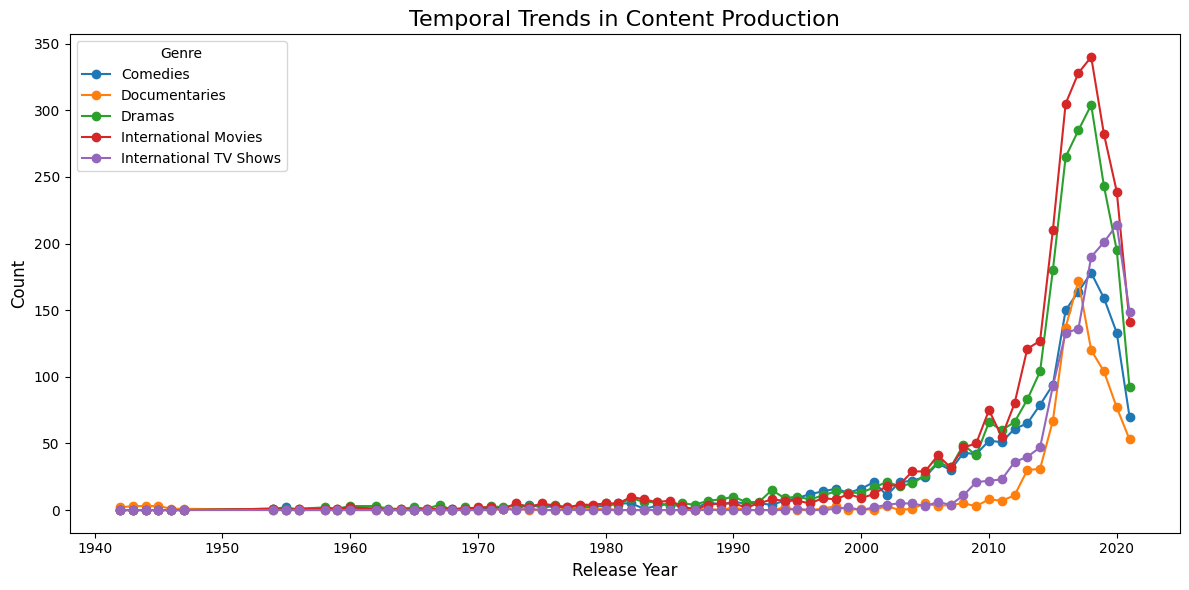

In [201]:
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')
top_genres = ['International Movies', 'Dramas', 'Comedies', 'International TV Shows', 'Documentaries']
df_filtered = df_exploded[df_exploded['genres'].isin(top_genres)]

# Count by year and genre
temporal_trends = df_filtered.groupby(['release_year', 'genres']).size().unstack().fillna(0)

# Plot
plt.figure(figsize=(12, 6))
temporal_trends.plot(marker='o', figsize=(12, 6))
plt.title('Temporal Trends in Content Production', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Genre', fontsize=10)
plt.tight_layout()
plt.show()

### Movie Recommendation

In [202]:
def preprocess_data(df):
    #Setting Maturity Levels for kids, Teens, Adults
    kid = df[df.rating.isin(['TV-Y','TV-Y7','G','PG'])].index
    teen = df[df.rating.isin(['PG-13','TV-14'])].index
    adult = df[df.rating.isin(['R','NC-17','nrur'])].index
    df.loc[kid, 'maturity_level'] = 'kid'
    df.loc[teen, 'maturity_level'] = 'teen'
    df.loc[adult, 'maturity_level'] = 'adult'

    # combining all the contents making a big string of knowledge
    df['content'] = df['title'].astype(str) + ' ' + df['director'].astype(str) + ' ' + df['cast'].astype(str) + ' ' + df['country'].astype(str) + ' ' + df['rating'].astype(str) + df['duration'].astype(str) + ' ' + df['listed_in'].astype(str) + ' ' + df['description'].astype(str)  + ' ' + df['maturity_level'].astype(str)
    df['content'] = df['content'].fillna('')

def create_tfidf_matrix(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['content'])
    return tfidf_matrix

# Function to create Bag of Words (BoW) matrix
def create_bow_matrix(df):
    count_vectorizer = CountVectorizer()
    bow_matrix = count_vectorizer.fit_transform(df['content'])
    return bow_matrix

# Function to compute TF-IDF cosine similarity
def tfidf_cosine_similarity(tfidf_matrix):
    cosine_sim = cosine_similarity(tfidf_matrix)
    return cosine_sim

# Function to compute BoW cosine similarity
def bow_cosine_similarity(bow_matrix):
    cosine_sim = cosine_similarity(bow_matrix)
    return cosine_sim

# Function to train Word2Vec model
def train_word2vec(df):
    df['tokenized_content'] = df['content'].apply(simple_preprocess)
    model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)
    model.build_vocab(df['tokenized_content'])
    model.train(df['tokenized_content'], total_examples=model.corpus_count, epochs=10)
    return model

# Function to average word vectors for a text
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.

    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features) for tokenized_sentence in corpus]
    return np.array(features)

# Function to compute Word2Vec-based similarity
def word2vec_similarity(user_movie, df):
    user_movie = find_similar_movies_fuzzy(df, user_movie)
    df['tokenized_content'] = df['content'].apply(simple_preprocess)
    model = Word2Vec(vector_size=100, window=5, min_count=1, workers=4)
    model.build_vocab(df['tokenized_content'])
    model.train(df['tokenized_content'], total_examples=model.corpus_count, epochs=10)
    movie_index = df[df['title'] == user_movie].index[0]
    w2v_feature_array = averaged_word_vectorizer(corpus=df['tokenized_content'], model=model, num_features=100)

    # Compute the cosine similarities between the user movie and all other movies
    user_movie_vector = w2v_feature_array[movie_index].reshape(1, -1)
    similarity_scores = cosine_similarity(user_movie_vector, w2v_feature_array)

    # Get the top 10 most similar movies
    similar_movies = list(enumerate(similarity_scores[0]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:20]

    # Print the top 10 similar movies
    for i, score in sorted_similar_movies:
        print("{}: {}".format(i, df.loc[i, 'title']))


# Function to compute BoW-based similarity
def bow_similarity(user_movie, df, bow_matrix):
    user_movie = find_similar_movies_fuzzy(df, user_movie)
    movie_index = df[df['title'] == user_movie].index[0]
    similarity_scores = bow_cosine_similarity(bow_matrix)
    similar_movies = list(enumerate(similarity_scores[movie_index]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:20]
    for i, score in sorted_similar_movies:
        print("{}: {}".format(i, df.loc[i, 'title']))

# Function to compute TF-IDF-based similarity
def tfidf_similarity(user_movie, df, tfidf_matrix):
    user_movie = find_similar_movies_fuzzy(df, user_movie)
    movie_index = df[df['title'] == user_movie].index[0]
    similarity_scores = tfidf_cosine_similarity(tfidf_matrix)
    similar_movies = list(enumerate(similarity_scores[movie_index]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1:20]
    for i, score in sorted_similar_movies:
        print("{}: {}".format(i, df.loc[i, 'title']))

# Function to find similar movies using fuzzy string matching
def find_similar_movies_fuzzy(df, movie_name):
    top_movies = process.extract(movie_name, df['title'], limit=5)
    return top_movies[0][0]

def similar_movies_fuzzy(df, movie_name):
    top_movies = process.extract(movie_name, df['title'], limit=5)
    print("Advanced Search and similar Alternatives")
    for movie, score, index in top_movies:
        print(f"Movie: {movie}, Similarity Score: {score}")


In [203]:
copied_df = df.copy()

In [204]:
# Preprocess data and create the 'content' column
preprocess_data(copied_df)

# Create the TF-IDF matrix and BoW matrix
tfidf_matrix = create_tfidf_matrix(copied_df)
bow_matrix = create_bow_matrix(copied_df)

In [205]:
# Assuming 'df' contains the cleaned dataset
df['content'] = df['title'] + " " + df['description'].fillna("")
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['content'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Build the graph
threshold = 0.1  # Similarity threshold
G = nx.Graph()

# Add nodes
for i, title in enumerate(df['title']):
    G.add_node(i, title=title)

# Add edges
for i in range(cosine_sim.shape[0]):
    for j in range(i + 1, cosine_sim.shape[1]):
        if cosine_sim[i, j] > threshold:
            G.add_edge(i, j, weight=cosine_sim[i, j])


In [206]:
def compute_Louvain_partition(G):
  # Apply Louvain clustering
  partition = community_louvain.best_partition(G)
  # Add cluster information to each node
  nx.set_node_attributes(G, partition, 'cluster')
  # Display number of clusters
  num_clusters = len(set(partition.values()))
  print(f"Number of clusters: {num_clusters}")
  return partition

In [207]:
def recommend_from_cluster(movie_title, df, G, partition, top_n=10):
    # Find the node corresponding to the movie title
    movie_node = None
    for node, data in G.nodes(data=True):
        if data['title'] == movie_title:
            movie_node = node
            break

    if movie_node is None:
        print(f"Movie '{movie_title}' not found in the graph.")
        return

    print(f"Node for '{movie_title}': {movie_node}")
    print(f"Edges for '{movie_title}': {list(G.edges(movie_node, data=True))}")

    # Find the cluster of the movie
    movie_cluster = partition.get(movie_node)
    if movie_cluster is None:
        print(f"'{movie_title}' does not belong to any cluster.")
        return

    # Get all movies in the same cluster
    cluster_movies = [node for node, cluster in partition.items() if cluster == movie_cluster]
    print(f"Movies in the same cluster: {len(cluster_movies)}")

    # Rank cluster movies by similarity
    recommendations = []
    for node in cluster_movies:
        if node != movie_node and G.has_edge(movie_node, node):
            similarity = G[movie_node][node]['weight']
            recommendations.append((df.iloc[node]['title'], similarity))

    # Sort by similarity and return top N
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)[:top_n]

    if not recommendations:
        print(f"No recommendations found for '{movie_title}' in the same cluster.")
        return

    print(f"Recommendations for '{movie_title}':")
    for title, score in recommendations:
        print(f"  - {title} (Similarity Score: {score:.2f})")


In [208]:
def Louvain_Movie_Recommendation(user_movie):
  partition = compute_Louvain_partition(G)
  recommend_from_cluster("The Matrix", df, G, partition, top_n=12)

In [209]:
def movie_recommendations(user_movie):
  similar_movies_fuzzy(copied_df, user_movie)

  print("\nSimilar Movies (TF-IDF Cosine Similarity):")
  tfidf_similarity(user_movie, copied_df, tfidf_matrix)

  print("\nSimilar Movies (BoW Cosine Similarity):")
  bow_similarity(user_movie, copied_df, bow_matrix)

  print("\nSimilar Movies (Word2Vec Similarity):")
  similarity_scores = word2vec_similarity(user_movie, copied_df)

  print("\nSimilar Movies (Graph Louvain Algorithm)")
  Louvain_Movie_Recommendation(user_movie)


In [210]:
# Get user input
user_movie = input("Enter a movie title: ")
movie_recommendations(user_movie)

Enter a movie title: The Matrix
Advanced Search and similar Alternatives
Movie: The Matrix, Similarity Score: 100
Movie: The Matrix Reloaded, Similarity Score: 90
Movie: The Matrix Revolutions, Similarity Score: 90
Movie: The Great British Baking Show, Similarity Score: 86
Movie: Vendetta: Truth, Lies and The Mafia, Similarity Score: 86

Similar Movies (TF-IDF Cosine Similarity):
8415: The Matrix Reloaded
8416: The Matrix Revolutions
8320: The Girl with the Dragon Tattoo
5658: Sense8
5958: 9
8591: Time Please
1852: Power Rangers Beast Morphers
3583: Sextuplets
880: Haunted
5474: Arès
7994: Shakti: The Power
3870: Code Geass: Lelouch of the Rebellion
1909: Free State of Jones
1692: America's Next Top Model
5548: Life 2.0
1837: Grand Army
5973: #Roxy
2526: She-Ra and the Princesses of Power
1749: Christmas Break-In

Similar Movies (BoW Cosine Similarity):
8415: The Matrix Reloaded
8416: The Matrix Revolutions
7151: Jupiter Ascending
6501: Cloud Atlas
8404: The Lord of the Rings: The Retu